# Analysis deep layer optogenetics 2

In [1]:
# the following two lines indicate that external functions are auto-reloaded as soon as they change. 
%load_ext autoreload
%autoreload 2
# Print statements 
from __future__ import print_function # Python 2.x

In [2]:
# General stuff:
import sys
import argparse
import os
import json
import numpy as np
import math
import psycopg2
import cPickle
import pandas as pd
import h5py

pd.options.mode.chained_assignment = None  # default='warn'

from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
from IPython.display import display, HTML

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *

# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general


In [3]:
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Yippiyeah! Database connection is established!')

Connecting to the PostgreSQL database...
Yippiyeah! Database connection is established!


In [4]:
# load the parameters to connect to data_1 
params = config()

## Analysis

Retrieve stimulus table for deep layer mice (**retro-cre**, **DIOCheta injections**)

In [5]:
salt_i_thresh = .1
salt_p_thresh = .05
inhib_p_thresh = .001 # arbitrary at the moment!

In [6]:
#%%time
#unique = "(cluster_no, tetrode_no, session_name, n_drive_user, animal_id, session_ts)"
#sql = "SELECT stimulus_tb.*, stimulus_mat_tb.spiketimes_cluster, stimulus_mat_tb.stimulus_timepoints,stimulus_mat_tb.sum_1ms,  \
#        stimulus_mat_tb.bin_edges_1ms, stimulus_mat_tb.binnumber_1ms \
#        FROM stimulus_tb INNER JOIN stimulus_mat_tb USING {} \
#        WHERE (stimulus_tb.animal_id = '70258' OR \
#        stimulus_tb.animal_id = '70644' OR stimulus_tb.animal_id = '70645' OR stimulus_tb.animal_id = '71343' \
#        OR stimulus_tb.animal_id = '71379' OR stimulus_tb.animal_id = '71461' OR stimulus_tb.animal_id = '71462' \
#        OR stimulus_tb.animal_id = '72254' OR stimulus_tb.animal_id = '72255' OR stimulus_tb.animal_id ='72878' \
#        OR stimulus_tb.animal_id = '71710' OR stimulus_tb.animal_id = '72257' OR stimulus_tb.animal_id= '72877' \
#        OR stimulus_tb.animal_id= '59391' OR stimulus_tb.animal_id= '59393' \
#        OR stimulus_tb.animal_id= '59392' OR stimulus_tb.animal_id= '59394' OR stimulus_tb.animal_id= '59381')\
#        ORDER BY stimulus_tb.session_ts ASC;".format(unique)
#sql_db_pd = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None,parse_dates=['session_ts'])
#print('{} entries found'.format(len(sql_db_pd)))

In [7]:
# if you want to save
export_path_pickle  = r"C:\work\python\klusta_analysis\postgres_notebooks\export_dataframes"
export_path_pickle = "/".join(export_path_pickle.split("\\"))
#sql_db_pd.to_pickle(export_path_pickle + "/all_deep_layer_stimulus.pkl")

In [8]:
deep_layer_exc_inhib_df = pd.read_pickle(export_path_pickle + "/all_deep_layer_stimulus.pkl")

In [9]:
len(deep_layer_exc_inhib_df)

11674

`deep_layer_exc_inhib_df` is an *unfiltered* stimulus/stimulus mat dataset of the deep layers.

### Draw timeline of stimulated / inhibited cells

Animal: 71379 First Stim. Day: 2017-02-09T11:04:29.000000000
Animal: 70644 First Stim. Day: 2017-02-14T09:59:15.000000000
Animal: 70645 First Stim. Day: 2017-02-14T10:51:01.000000000
Animal: 71343 First Stim. Day: 2017-02-14T11:38:56.000000000
Animal: 72255 First Stim. Day: 2017-03-15T16:48:31.000000000
Animal: 72254 First Stim. Day: 2017-03-16T13:27:44.000000000
Animal: 71461 First Stim. Day: 2017-03-20T15:46:22.000000000
Animal: 71462 First Stim. Day: 2017-03-20T16:36:48.000000000
Animal: 72877 First Stim. Day: 2017-03-29T10:32:11.000000000
Animal: 72257 First Stim. Day: 2017-04-03T14:25:09.000000000
Animal: 72878 First Stim. Day: 2017-04-10T11:18:43.000000000
Animal: 71710 First Stim. Day: 2017-04-10T11:46:38.000000000
Animal: 59394 First Stim. Day: 2017-04-25T15:15:01.000000000
Animal: 59393 First Stim. Day: 2017-05-04T17:45:32.000000000


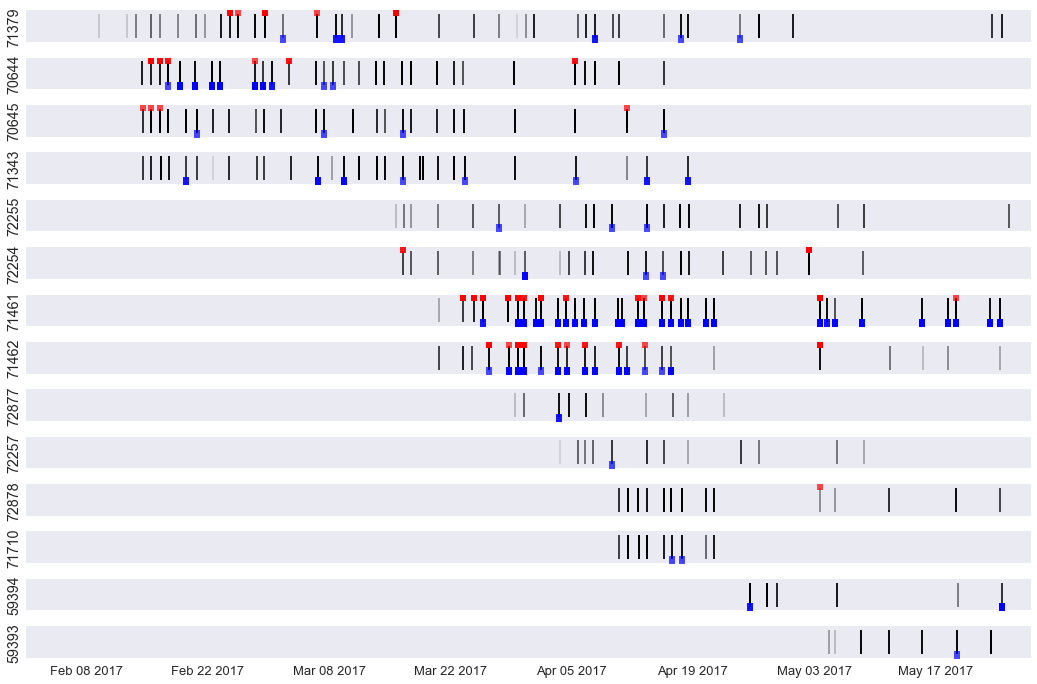

In [10]:
# plot stimulated cells over time for each animal:
figure = plt.figure(figsize=(18,15))
sns.set(font_scale=1.3)
sns.set_style('dark')
counter_fig = 1

for animal in deep_layer_exc_inhib_df.animal_id.unique():
    exc_found = len(deep_layer_exc_inhib_df.session_ts[(deep_layer_exc_inhib_df.animal_id == animal) & 
                                             (deep_layer_exc_inhib_df.salt_i > salt_i_thresh) & 
                                             (deep_layer_exc_inhib_df.salt_p < salt_p_thresh)]) 
                                                           
    inhib_found = len(deep_layer_exc_inhib_df.session_ts[(deep_layer_exc_inhib_df.animal_id == animal) & 
                                             (deep_layer_exc_inhib_df.inhib_lowest_p < inhib_p_thresh)])        
     
    if (exc_found > 0 or inhib_found > 0):
        first_recording = deep_layer_exc_inhib_df.session_ts[(deep_layer_exc_inhib_df.animal_id == animal)].values[0]
        print('Animal: {} First Stim. Day: {}'.format(animal,first_recording))
        
        ax = figure.add_subplot(len(deep_layer_exc_inhib_df.animal_id.unique()),1,counter_fig)
        ax.scatter(deep_layer_exc_inhib_df.session_ts[(deep_layer_exc_inhib_df.animal_id == animal)].values,
                   np.ones(len(deep_layer_exc_inhib_df[(deep_layer_exc_inhib_df.animal_id == animal)])),
                   s=570,c='k',label=animal,marker='|',alpha=.5,lw=.2)
        
        # draw marker for excited
        ax.scatter(deep_layer_exc_inhib_df.session_ts[(deep_layer_exc_inhib_df.animal_id == animal) & 
                                                      (deep_layer_exc_inhib_df.salt_i > salt_i_thresh) & 
                                                      (deep_layer_exc_inhib_df.salt_p < salt_p_thresh)].values,
                   deep_layer_exc_inhib_df.excited[(deep_layer_exc_inhib_df.animal_id == animal) & 
                                                   (deep_layer_exc_inhib_df.salt_i > salt_i_thresh) & 
                                                   (deep_layer_exc_inhib_df.salt_p < salt_p_thresh)].astype(int)+.5,
                   s=150,c='r',label=animal,marker='|',alpha=.7,linewidth=6)
        
        # draw marker for inhibited
        ax.scatter(deep_layer_exc_inhib_df.session_ts[(deep_layer_exc_inhib_df.animal_id == animal) & 
                                                      (deep_layer_exc_inhib_df.inhib_lowest_p < inhib_p_thresh)].values,
                   deep_layer_exc_inhib_df.inhibited[(deep_layer_exc_inhib_df.animal_id == animal) & 
                                                   (deep_layer_exc_inhib_df.inhib_lowest_p < inhib_p_thresh)].astype(int)-.5,
                   s=200,c='b',label=animal,marker='|',alpha=.7,linewidth=6)
        
        #ax.axvline(x=first_recording,linewidth=2, color='k')
        ax.get_yaxis().set_ticks([])
        [label.set_visible(False) for label in ax.get_xticklabels()]
        ax.set_ylim(0.5,1.5)
        ax.set_xlim([date(2017, 2, 1), date(2017, 5, 28)])
        ax.set_ylabel(animal)
        counter_fig +=1 
        sns.despine(bottom=True)
[label.set_visible(True) for label in ax.get_xticklabels()]     
figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.show()

In [11]:
#subsets
deep_layer_inhib = deep_layer_exc_inhib_df[(deep_layer_exc_inhib_df.inhib_lowest_p < inhib_p_thresh) & 
                                          (deep_layer_exc_inhib_df.inhibited == True)]
deep_layer_exc = deep_layer_exc_inhib_df[(deep_layer_exc_inhib_df.salt_i > salt_i_thresh) & 
                                         (deep_layer_exc_inhib_df.salt_p < salt_p_thresh)]
deep_layer_rest = deep_layer_exc_inhib_df.iloc[[x for x in deep_layer_exc_inhib_df.index if (x not in deep_layer_exc.index)&
                                                (x not in deep_layer_inhib.index)]]

In [12]:
# sort dataframes!
deep_layer_inhib.sort_values('inhib_lowest_p',ascending=True, inplace=True)
deep_layer_exc.sort_values('salt_i',ascending=False, inplace=True)

In [14]:
# groupby (to count occurences = number of sessions that met threshold criterion)
grouped_excited_count = deep_layer_exc.groupby(['session_ts','animal_id','tetrode_no','cluster_no']).count()
grouped_inhibited_count = deep_layer_inhib.groupby(['session_ts','animal_id','tetrode_no','cluster_no']).count()

# and reset index
grouped_excited_count.reset_index(inplace=True)
grouped_inhibited_count.reset_index(inplace=True)

In [16]:
# drop duplicates (maintaining the most significant / highest I session)
deep_layer_exc.drop_duplicates(subset=['session_ts','animal_id','tetrode_no','cluster_no'],inplace=True)
deep_layer_inhib.drop_duplicates(subset=['session_ts','animal_id','tetrode_no','cluster_no'],inplace=True)
deep_layer_rest.drop_duplicates(subset=['session_ts','animal_id','tetrode_no','cluster_no'],inplace=True)

In [17]:
# reset indices
deep_layer_inhib.reset_index(drop=True,inplace=True)
deep_layer_exc.reset_index(drop=True,inplace=True)
deep_layer_rest.reset_index(drop=True,inplace=True)

In [18]:
# update columns excited / inhibited
deep_layer_exc['inhibited'] = (deep_layer_exc.inhib_lowest_p < inhib_p_thresh) & (deep_layer_exc.inhibited == True)
deep_layer_exc['excited'] = (deep_layer_exc.salt_i > salt_i_thresh) & (deep_layer_exc.salt_p < salt_p_thresh)
deep_layer_inhib['inhibited'] = (deep_layer_inhib.inhib_lowest_p < inhib_p_thresh) & (deep_layer_inhib.inhibited == True)
deep_layer_inhib['excited'] = (deep_layer_inhib.salt_i > salt_i_thresh) & (deep_layer_inhib.salt_p < salt_p_thresh)
deep_layer_rest['inhibited'] = (deep_layer_rest.inhib_lowest_p < inhib_p_thresh) & (deep_layer_rest.inhibited == True)
deep_layer_rest['excited'] = (deep_layer_rest.salt_i > salt_i_thresh) & (deep_layer_rest.salt_p < salt_p_thresh)

### Retrieve additional entries from other tables to filter on

In [19]:
waveforms_cells = pd.DataFrame()
isi_stats_cells =  pd.DataFrame()

# concatenate three datasets for every dataframe...

for df in tqdm_notebook([deep_layer_exc,deep_layer_inhib,deep_layer_rest]):
    for i in tqdm_notebook(xrange(len(df))):
        c_entry = df.iloc[i]

        if np.isnan(float(c_entry.animal_id)): print('skipping.');skipped+=1;continue

        # waveforms base session
        sql = "SELECT mean_wf,std_wf,maxima_wf FROM waveforms_tb \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%'".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['mean_wf','std_wf','maxima_wf']]],axis=1) # horizontally join the two entries
            waveforms_cells = pd.concat([waveforms_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['mean_wf'],c_entry_T['std_wf'],c_entry_T['maxima_wf'] = np.nan,np.nan,np.nan
            waveforms_cells = pd.concat([waveforms_cells,  c_entry_T], axis=0) # vertically join it with the rest   
            
        # isi stats
        sql = "SELECT ISI_stats_contam, ISI_stats_contam_perc, ISI_stats_percent_bursts FROM ISI_tb \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,
                                                               c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['isi_stats_contam','isi_stats_contam_perc',
                                                 'isi_stats_percent_bursts']]],axis=1) # horizontally join the two entries
            isi_stats_cells = pd.concat([isi_stats_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['isi_stats_contam'],c_entry_T['isi_stats_contam_perc'],c_entry_T['isi_stats_percent_bursts'] = np.nan,np.nan,np.nan
            isi_stats_cells = pd.concat([isi_stats_cells,  c_entry_T], axis=0) # vertically join it with the rest   
            
print('Finished.')


Finished.


#### Right now you have:
- waveforms_cells 
- isi_stats_cells 
- deep_layer_exc
- deep_layer_inhib
- deep_layer_rest

**Employ additional filtering criteria**: 
- *Generally*: include only cells with ISI contam < 1%
- *Generally*: include only cells for which criterion level was reached in more than one session (excitation / inhibition)
- For excited cells include only cells which have pearson corr of waveform > .9
- For inhibited cells include only cells whose most significant p interval (!) > 10 ms
    - (later check for these inhibited cells, whether the p-value becomes insignificant at 40 ms (indicating short inhibition))

- then also look up BNT scores, autocorr scores and ISI_burst score (after all that filtering and for every dataset)

In [20]:
isi_cutoff = 1 # %
pearson_r_cutoff = 0.99
min_no_sessions = 1

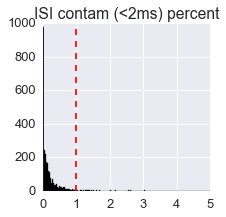

In [21]:
# seek justification for arbitrary threshold ;) 
sns.set_style('darkgrid')
figure = plt.figure(figsize=(3,3))
isi_stats_cells.isi_stats_contam_perc.hist(bins=500, color='k')
plt.xlim(0,5)
plt.axvline(x=isi_cutoff,color='red',linestyle='--')
plt.title('ISI contam (<2ms) percent')
sns.despine()

In [22]:
# Before filtering, these cell numbers remain at the moment: 
print('deep_layer_exc ({}), deep_layer_inhib ({}), deep_layer_rest({})'.format(len(deep_layer_exc),len(deep_layer_inhib),len(deep_layer_rest)))
print('Total before filtering: {}'.format(len(deep_layer_exc)+len(deep_layer_inhib)+len(deep_layer_rest)))

deep_layer_exc (70), deep_layer_inhib (271), deep_layer_rest(2457)
Total before filtering: 2798


##### ... for excited cells 

In [23]:
def extract_wv_from_c_entry(c_entry):
    '''
    Since some laser sessions were skipped in the spatial analysis,
    waveforms (wf) are missing for some sessions ... extract them manually now
    '''
    waveforms = extract_waveforms(c_entry.filename)
    basenames = get_basenames(c_entry.filename)

    with h5py.File(c_entry.filename, mode="r") as f:
        boolean = np.array(f['/channel_groups/1/spikes/clusters/main'][:])==c_entry.cluster_no

    spiketimes,sample_rate,time_stamps, time_stamps_sessions, time_stamps_sessions_sample_rate = extract_times(c_entry.filename)    
    spiketimes_cluster = spiketimes[boolean]/sample_rate # in s
    spike_chs_wfs = [waveforms[boolean,:,0], waveforms[boolean,:,1],waveforms[boolean,:,2],waveforms[boolean,:,3]]  
    indices_session =  get_session_indices(basenames,spiketimes_cluster,time_stamps,sample_rate)
    no_session = np.where(basenames ==c_entry.session_name)

    mean_wf, std_wf, maxima_wf = get_waveforms_stats(spike_chs_wfs,indices_session,no_session[0][0])
    return  mean_wf, std_wf, maxima_wf

##### make sure that the datasets (count and exc) match!

[6]
Extracted waveforms.
Extracted spiketimes.


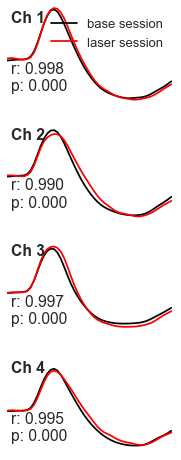

Median pearsons r: 0.995569738133
[4]
Extracted waveforms.
Extracted spiketimes.


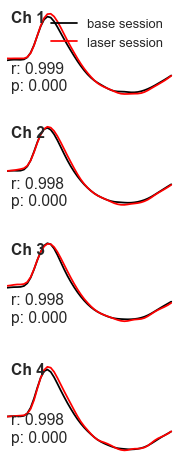

Median pearsons r: 0.998121304585
[3]
Extracted waveforms.
Extracted spiketimes.


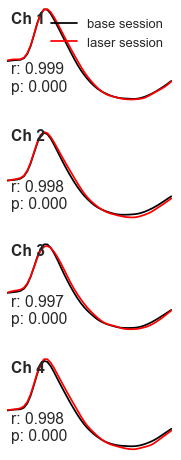

Median pearsons r: 0.997806369343
[6]
Extracted waveforms.
Extracted spiketimes.


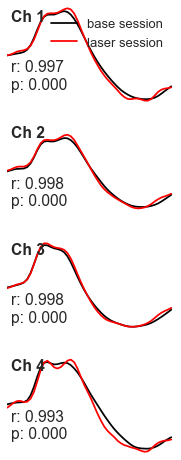

Median pearsons r: 0.997518599974
[5]
Extracted waveforms.
Extracted spiketimes.


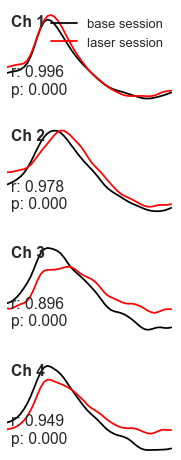

Median pearsons r: 0.963387746296
[7]
Extracted waveforms.
Extracted spiketimes.


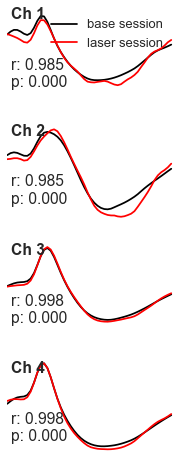

Median pearsons r: 0.991713806307
[6]
Extracted waveforms.
Extracted spiketimes.


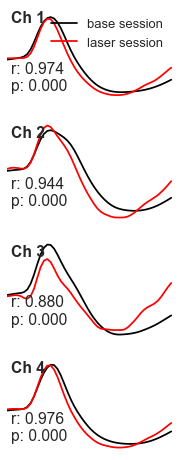

Median pearsons r: 0.958904827864
[4]
Extracted waveforms.
Extracted spiketimes.


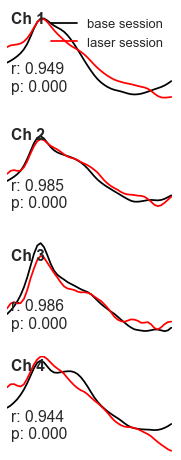

Median pearsons r: 0.967066538539
[4]
Extracted waveforms.
Extracted spiketimes.


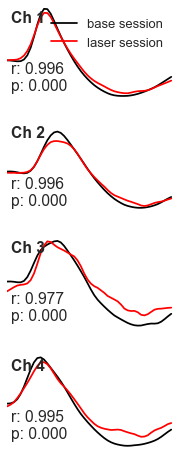

Median pearsons r: 0.995757070801
[6]
Extracted waveforms.
Extracted spiketimes.


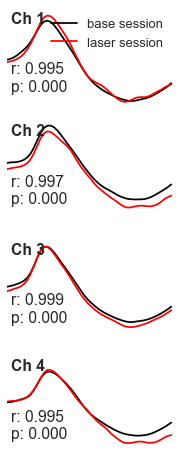

Median pearsons r: 0.996378781354
[2]
Extracted waveforms.
Extracted spiketimes.


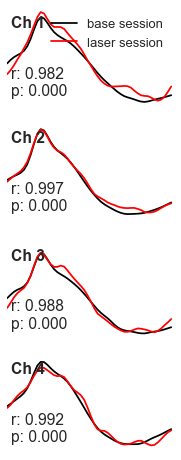

Median pearsons r: 0.990094488656
[1]
Dropped!
[4]
Extracted waveforms.
Extracted spiketimes.


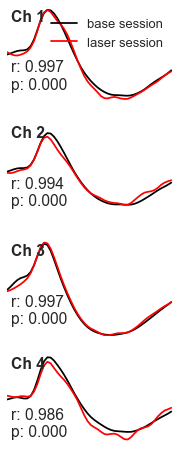

Median pearsons r: 0.995798629092
[1]
Dropped!
[5]
Extracted waveforms.
Extracted spiketimes.


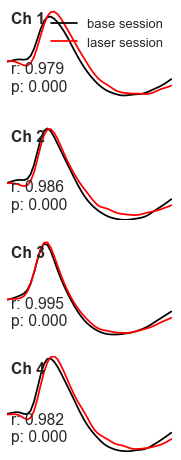

Median pearsons r: 0.984352871642
[4]
Extracted waveforms.
Extracted spiketimes.


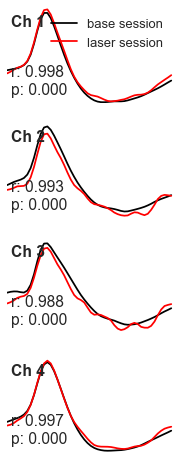

Median pearsons r: 0.994920246834
[4]
Extracted waveforms.
Extracted spiketimes.


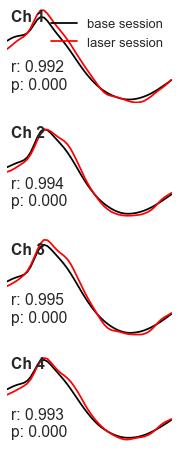

Median pearsons r: 0.993211767915
[3]
Extracted waveforms.
Extracted spiketimes.


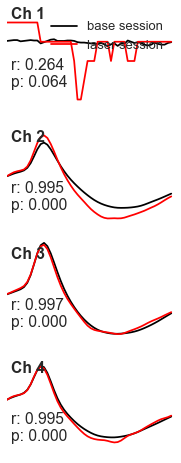

Median pearsons r: 0.99524396906
[1]
Dropped!
[1]
Dropped!
[4]
Extracted waveforms.
Extracted spiketimes.


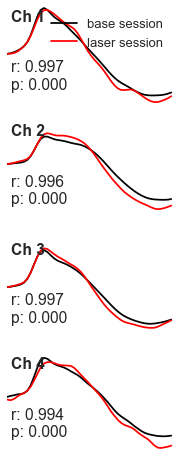

Median pearsons r: 0.996379841041
[2]
Extracted waveforms.
Extracted spiketimes.


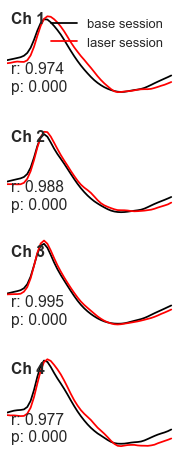

Median pearsons r: 0.982780450169
[1]
Dropped!
[4]
Extracted waveforms.
Extracted spiketimes.


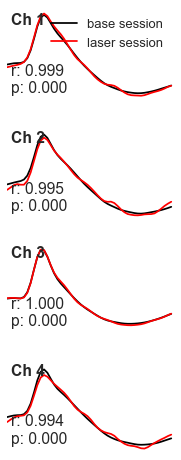

Median pearsons r: 0.996672402477
[2]
Extracted waveforms.
Extracted spiketimes.


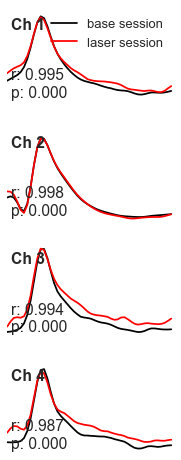

Median pearsons r: 0.994087438456
[2]
Extracted waveforms.
Extracted spiketimes.


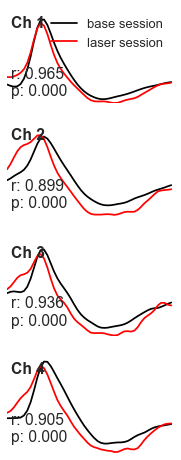

Median pearsons r: 0.920876444965
[3]
Extracted waveforms.
Extracted spiketimes.


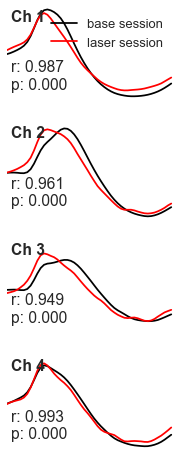

Median pearsons r: 0.974248175654
[1]
Dropped!
[2]
Extracted waveforms.
Extracted spiketimes.


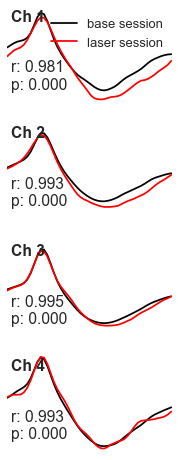

Median pearsons r: 0.993332069313
[2]
Extracted waveforms.
Extracted spiketimes.


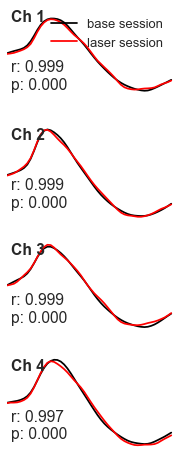

Median pearsons r: 0.99859891185
[1]
Dropped!
[1]
Dropped!
[1]
Dropped!
[2]
Extracted waveforms.
Extracted spiketimes.


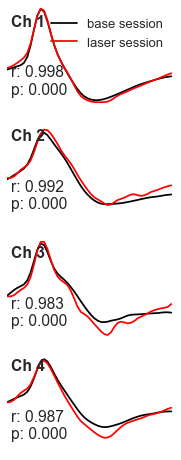

Median pearsons r: 0.989415719584
[1]
Dropped!
[1]
Dropped!
[1]
Dropped!
[2]
Extracted waveforms.
Extracted spiketimes.


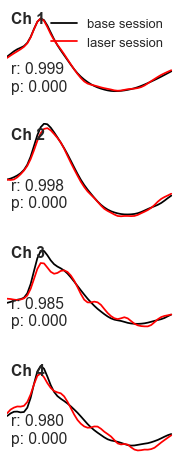

Median pearsons r: 0.991393299287
[1]
Dropped!
[1]
Dropped!
[1]
Dropped!
[1]
Dropped!
[1]
Dropped!
[1]
Dropped!
[1]
Dropped!
[1]
Dropped!
[1]
Dropped!
[1]
Dropped!
[2]
Extracted waveforms.
Extracted spiketimes.


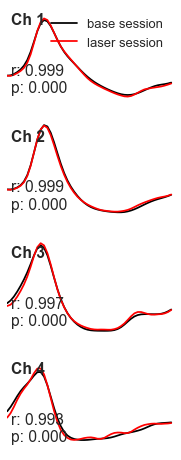

Median pearsons r: 0.997903437374
[1]
Dropped!

19 clusters remaining from excited cells.


In [24]:
# go through excited cells and employ filter criteria: 
# no "offset" here! (since it is the first dataset in a row)
indices_to_keep = []
for no in tqdm_notebook(xrange(len(deep_layer_exc))):
    if isi_stats_cells.isi_stats_contam_perc.values[no] < isi_cutoff:
        
        
        count_sessions = grouped_excited_count.session_name.values[(grouped_excited_count.cluster_no == deep_layer_exc.cluster_no[no]) & 
                              (grouped_excited_count.tetrode_no == deep_layer_exc.tetrode_no[no]) & 
                              (grouped_excited_count.animal_id == deep_layer_exc.animal_id[no]) & 
                              (grouped_excited_count.session_ts == deep_layer_exc.session_ts[no])]
        

        print(count_sessions)
                                                                                    
        if count_sessions > min_no_sessions:
            # now calculate pearson's between waveforms on all channels
            # get waveforms for laser session: 
            mean_wf_las, std_wf_las, maxima_wf_las = extract_wv_from_c_entry(deep_layer_exc.iloc[no])
            # calculate pearson's r,p
            all_pears_r,all_pears_p = plot_waveform_base_laser(waveforms_cells,mean_wf_las,no,plotting=True)
            if np.median(all_pears_r) > pearson_r_cutoff:
                indices_to_keep.append(no)
            print('Median pearson''s r: {}'.format(np.median(all_pears_r)))
        else:
            print('Dropped!')
print('{} clusters remaining from excited cells.'.format(len(indices_to_keep)))

In [26]:
deep_layer_exc_filtered = deep_layer_exc.iloc[indices_to_keep]

##### ... for inhibited cells

In [27]:
# go through inhibited cells and employ filter criteria: 
indices_to_keep = []
offset = len(deep_layer_exc) # Need this offset because isi_stats are all concatenated
for no in tqdm_notebook(xrange(len(deep_layer_inhib))):
    if isi_stats_cells.isi_stats_contam_perc.values[no+offset] < isi_cutoff:
                        
        count_sessions = grouped_inhibited_count.session_name.values[(grouped_inhibited_count.cluster_no == deep_layer_inhib.cluster_no[no]) & 
                              (grouped_inhibited_count.tetrode_no == deep_layer_inhib.tetrode_no[no]) & 
                              (grouped_inhibited_count.animal_id == deep_layer_inhib.animal_id[no]) & 
                              (grouped_inhibited_count.session_ts == deep_layer_inhib.session_ts[no])]
        
        if count_sessions > min_no_sessions:
                if deep_layer_inhib.inhib_lowest_p_interval.iloc[no] > 10:
                    indices_to_keep.append(no)
print('{} clusters remaining from inhibited cells.'.format(len(indices_to_keep)))


157 clusters remaining from inhibited cells.


In [28]:
deep_layer_inhib_filtered = deep_layer_inhib.iloc[indices_to_keep]

##### ... for the remaining cells

In [29]:
# go through all remaining cells and employ filter criteria: 
indices_to_keep = []
offset = len(deep_layer_exc) + len(deep_layer_inhib) # Need this offset because isi_stats are all concatenated
for no in tqdm_notebook(xrange(len(deep_layer_rest))):
    if isi_stats_cells.isi_stats_contam_perc.values[no+offset] < isi_cutoff:
                    indices_to_keep.append(no)
print('{} clusters remaining from remaining cells.'.format(len(indices_to_keep)))


2323 clusters remaining from remaining cells.


In [30]:
deep_layer_rest_filtered = deep_layer_rest.iloc[indices_to_keep]

**Now you have filtered datasets for**
- deep_layer_exc_filtered (filtered for good ISI, session counter > 1, and pearson's r > 0.99)
- deep_layer_inhib_filtered (filtered for good ISI, session counter > 1 and lowest p interval > 10ms)
- deep_layer_rest_filtered (filtered for good ISI)

Careful: Isi_stats and waveforms_cells are not filtered! 

### Retrieve rest of useful information to plot

In [31]:
autocorr_cells = pd.DataFrame()
ratemaps_cells = pd.DataFrame()
obj_ratemaps_cells = pd.DataFrame()
bnt_scores_cells = pd.DataFrame()
hd_tuning_cells = pd.DataFrame()
obj_hd_tuning_cells = pd.DataFrame()

spiketimes_tracking_cells = pd.DataFrame()
obj_spiketimes_tracking_cells = pd.DataFrame()

# concatenate three datasets for every dataframe...

for df in tqdm_notebook([deep_layer_exc_filtered,deep_layer_inhib_filtered,deep_layer_rest_filtered]):
    for i in tqdm_notebook(xrange(len(df))):
        c_entry = df.iloc[i]

        if np.isnan(float(c_entry.animal_id)): print('skipping.');skipped+=1;continue

        # retrieve the base session stats:
        # autocorr (st_autocorr_tb):
        sql = "SELECT theta_idx, burst_idx1, burst_idx2 FROM st_autocorr_tb \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['theta_idx','burst_idx1','burst_idx2']]],axis=1) # horizontally join the two entries
            autocorr_cells = pd.concat([autocorr_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['theta_idx'],c_entry_T['burst_idx1'],c_entry_T['burst_idx2'] = np.nan,np.nan,np.nan
            autocorr_cells = pd.concat([autocorr_cells,  c_entry_T], axis=0) # vertically join it with the rest         
        
        
        # ratemaps (ratemaps_tb):
        sql = "SELECT masked_ratemap FROM ratemaps_tb \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['masked_ratemap']]],axis=1) # horizontally join the two entries
            ratemaps_cells = pd.concat([ratemaps_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            fake_map = fake_ratemap()
            c_entry_T['fake_ratemap'] = [np.array(fake_map)]
            ratemaps_cells = pd.concat([ratemaps_cells,  c_entry_T], axis=0) # vertically join it with the rest
               
                
        # object ratemaps (ratemaps_tb):
        sql = "SELECT masked_ratemap FROM ratemaps_tb \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND \
              session_name LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['masked_ratemap']]],axis=1) # horizontally join the two entries
            obj_ratemaps_cells = pd.concat([obj_ratemaps_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            fake_map = fake_ratemap()
            c_entry_T['fake_ratemap'] = [np.array(fake_map)]
            obj_ratemaps_cells = pd.concat([obj_ratemaps_cells,  c_entry_T], axis=0) # vertically join it with the rest
       
        # bnt scores
        sql = "SELECT gridscore,borderscore,mvl,informationcontent,informationrate,meanrate,peakrate,speedscore FROM BNT_scores_tb \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['gridscore','borderscore','mvl','informationcontent','informationrate','meanrate','peakrate','speedscore']]],axis=1) # horizontally join the two entries
            bnt_scores_cells = pd.concat([bnt_scores_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['gridscore'], c_entry_T['borderscore'], c_entry_T['mvl'], c_entry_T['informationcontent'], c_entry_T['informationrate'],c_entry_T['meanrate'],c_entry_T['peakrate'],c_entry_T['speedscore'] = np.nan, np.nan, np.nan, np.nan, np.nan,np.nan, np.nan, np.nan
            bnt_scores_cells = pd.concat([bnt_scores_cells,  c_entry_T], axis=0) # vertically join it with the rest
      
        # spiketimes tracking stuff
        sql = "SELECT spiket_tracking_session, mean_freq FROM spiketimes_tracking_tb  \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['spiket_tracking_session','mean_freq']]],axis=1) # horizontally join the two entries
            spiketimes_tracking_cells = pd.concat([spiketimes_tracking_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['spiket_tracking_session'], c_entry_T['mean_freq'] = np.nan, np.nan
            spiketimes_tracking_cells = pd.concat([spiketimes_tracking_cells,  c_entry_T], axis=0) # vertically join it with the rest
        
        # spiketimes tracking stuff - object
        sql = "SELECT spiket_tracking_session, mean_freq FROM spiketimes_tracking_tb  \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name \
              LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['spiket_tracking_session','mean_freq']]],axis=1) # horizontally join the two entries
            obj_spiketimes_tracking_cells = pd.concat([obj_spiketimes_tracking_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['spiket_tracking_session'], c_entry_T['mean_freq'] = np.nan, np.nan
            obj_spiketimes_tracking_cells = pd.concat([obj_spiketimes_tracking_cells,  c_entry_T], axis=0) # vertically join it with the rest

        # HD tuning stuff 
        sql = "SELECT bins_angle_center, hist_angle_smooth,tc_stats_MVL,tc_stats_mean,tc_stats_var FROM hd_tuning_tb  \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['bins_angle_center','hist_angle_smooth','tc_stats_mvl','tc_stats_mean','tc_stats_var']]],axis=1) # horizontally join the two entries
            hd_tuning_cells = pd.concat([hd_tuning_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['bins_angle_center'], c_entry_T['hist_angle_smooth'],c_entry_T['tc_stats_mvl'], c_entry_T['tc_stats_mean'],c_entry_T['tc_stats_var']  = np.nan, np.nan,np.nan, np.nan,np.nan
            hd_tuning_cells = pd.concat([hd_tuning_cells,  c_entry_T], axis=0) # vertically join it with the rest

        # HD tuning stuff - object 
        sql = "SELECT bins_angle_center, hist_angle_smooth,tc_stats_MVL,tc_stats_mean,tc_stats_var FROM hd_tuning_tb  \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name LIKE \
              '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['bins_angle_center','hist_angle_smooth','tc_stats_mvl','tc_stats_mean','tc_stats_var']]],axis=1) # horizontally join the two entries
            obj_hd_tuning_cells = pd.concat([obj_hd_tuning_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['bins_angle_center'], c_entry_T['hist_angle_smooth'],c_entry_T['tc_stats_mvl'], c_entry_T['tc_stats_mean'],c_entry_T['tc_stats_var']  = np.nan, np.nan,np.nan, np.nan,np.nan
            obj_hd_tuning_cells = pd.concat([obj_hd_tuning_cells,  c_entry_T], axis=0) # vertically join it with the rest
                             
                
print('Finished.')


Finished.


#### also retrieve tracking and LFP stuff (base sessions only)

In [32]:
tracking_cells = pd.DataFrame()
obj_tracking_cells = pd.DataFrame()
lfp_cells = pd.DataFrame()

for df in tqdm_notebook([deep_layer_exc_filtered,deep_layer_inhib_filtered,deep_layer_rest_filtered]):
    df = df.drop_duplicates(subset=['session_ts','animal_id']) # for LFP and tracking data drop duplicates
    df.reset_index(drop=True,inplace=True)
     
    for i in tqdm_notebook(xrange(len(df))):
        c_entry = df.iloc[i]

        if np.isnan(float(c_entry.animal_id)): print('skipping.');skipped+=1;continue

        #  tracking stuff 
        sql = "SELECT tracking_session, px_to_cm FROM tracking_tb \
              WHERE animal_id = '{}' AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['tracking_session','px_to_cm']]],axis=1) # horizontally join the two entries
            tracking_cells = pd.concat([tracking_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['tracking_session'], c_entry_T['px_to_cm'] = np.nan, np.nan
            tracking_cells = pd.concat([tracking_cells,  c_entry_T], axis=0) # vertically join it with the rest
            
        #  tracking stuff - object
        sql = "SELECT tracking_session, px_to_cm FROM tracking_tb \
              WHERE animal_id = '{}' AND \
              session_ts = '{}' AND session_name \
              LIKE '%obj%';".format(c_entry.animal_id, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['tracking_session','px_to_cm']]],axis=1) # horizontally join the two entries
            obj_tracking_cells = pd.concat([obj_tracking_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['tracking_session'], c_entry_T['px_to_cm'] = np.nan, np.nan
            obj_tracking_cells = pd.concat([obj_tracking_cells,  c_entry_T], axis=0) # vertically join it with the rest
               
        #  LFP stuff 
        sql = "SELECT lfp_session, theta_freq FROM lfp_tb\
              WHERE animal_id = '{}' AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['lfp_session','theta_freq']]],axis=1) # horizontally join the two entries
            lfp_cells = pd.concat([lfp_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['lfp_session'], c_entry_T['theta_freq'] = np.nan, np.nan
            lfp_cells = pd.concat([lfp_cells,  c_entry_T], axis=0) # vertically join it with the rest

#### You now have: 
- autocorr_cells
- ratemaps_cells 
- obj_ratemaps_cells 
- bnt_scores_cells 
- spiketimes_tracking_cells


- tracking_cells
- lfp_cells

based on: 
- deep_layer_exc_filtered
- deep_layer_inhib_filtered
- deep_layer_rest_filtered

### Save for later retrieval:

In [33]:
# if you want to save
deep_layer_exc_filtered.to_pickle(export_path_pickle + "/deep_layer_exc_filtered.pkl")
deep_layer_inhib_filtered.to_pickle(export_path_pickle + "/deep_layer_inhib_filtered.pkl")
deep_layer_rest_filtered.to_pickle(export_path_pickle + "/deep_layer_rest_filtered.pkl")

autocorr_cells.to_pickle(export_path_pickle + "/autocorr_cells.pkl")
ratemaps_cells.to_pickle(export_path_pickle + "/ratemaps_cells.pkl")
obj_ratemaps_cells.to_pickle(export_path_pickle + "/obj_ratemaps_cells.pkl")
bnt_scores_cells.to_pickle(export_path_pickle + "/bnt_scores_cells.pkl")
spiketimes_tracking_cells.to_pickle(export_path_pickle + "/spiketimes_tracking_cells.pkl")
obj_spiketimes_tracking_cells.to_pickle(export_path_pickle + "/obj_spiketimes_tracking_cells.pkl")

tracking_cells.to_pickle(export_path_pickle + "/tracking_cells.pkl")
obj_tracking_cells.to_pickle(export_path_pickle + "/obj_tracking_cells.pkl")
lfp_cells.to_pickle(export_path_pickle + "/lfp_cells.pkl")
hd_tuning_cells.to_pickle(export_path_pickle + "/hd_tuning_cells.pkl")

In [34]:
obj_hd_tuning_cells.to_pickle(export_path_pickle + "/obj_hd_tuning_cells.pkl")